In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Sample data (replace with your actual data)
data = pd.DataFrame({
    'Date': pd.date_range('2023-01-01', periods=100),
    'Price': np.random.randn(100).cumsum() + 100
})

data

,Date,Price
0,2023-01-01,100.311544
1,2023-01-02,101.819842
2,2023-01-03,100.686675
3,2023-01-04,99.149977
4,2023-01-05,98.115895
...,...,...
95,2023-04-06,106.501780
96,2023-04-07,108.247831
97,2023-04-08,109.682871
98,2023-04-09,108.844371


In [21]:
# Function to identify trendlines
def find_trendlines(data, split_index):
    df = data.copy()
    df['Number'] = np.arange(len(df)) + 1
    first_part = df.iloc[:split_index].copy()

    # Calculate uptrend line from peaks
    df_high = first_part[['Number', 'Price']].copy()
    while len(df_high) > 2:
        slope_up, intercept_up, _, _, _ = linregress(x=df_high['Number'], y=df_high['Price'])
        df_high = df_high.loc[df_high['Price'] > slope_up * df_high['Number'] + intercept_up]

    # Calculate downtrend line from valleys
    df_low = first_part[['Number', 'Price']].copy()
    while len(df_low) > 2:
        slope_down, intercept_down, _, _, _ = linregress(x=df_low['Number'], y=df_low['Price'])
        df_low = df_low.loc[df_low['Price'] < slope_down * df_low['Number'] + intercept_down]

    # Determine overall trend
    total_trend = "upward" if slope_up > 0 else "downward"

    df['Uptrend'] = slope_up * df['Number'] + intercept_up
    df['Downtrend'] = slope_down * df['Number'] + intercept_down

    return df, slope_up, intercept_up, slope_down, intercept_down, total_trend

In [26]:
# Function to score the second portion based on trendlines and trend direction
def score_trendlines(data, split_index, slope_up, intercept_up, slope_down, intercept_down, total_trend):
    second_part = data.iloc[split_index:].copy()
    second_part['Number'] = np.arange(len(second_part)) + split_index + 1

    scores = []
    was_breaking_uptrend = False
    was_breaking_downtrend = False

    for _, row in second_part.iterrows():
        price = row['Price']
        uptrend = slope_up * row['Number'] + intercept_up
        downtrend = slope_down * row['Number'] + intercept_down
        score = 0

        if total_trend == "upward":
            # Trendline from valleys
            if price < downtrend:
                if not was_breaking_downtrend:
                    score = -10  # Break
                    was_breaking_downtrend = True
                else:
                    was_breaking_downtrend = True
            elif price == downtrend:
                score = 10  # Collision
                was_breaking_downtrend = False
            else:
                was_breaking_downtrend = False

            # Trendline from peaks
            if price > uptrend:
                if not was_breaking_uptrend:
                    score = 7  # Break
                    was_breaking_uptrend = True
                else:
                    was_breaking_uptrend = True
            elif price == uptrend:
                score = -10  # Collision
                was_breaking_uptrend = False
            else:
                was_breaking_uptrend = False

        elif total_trend == "downward":
            # Trendline from peaks
            if price > uptrend:
                if not was_breaking_uptrend:
                    score = 10  # Break
                    was_breaking_uptrend = True
                else:
                    was_breaking_uptrend = True
            elif price == uptrend:
                score = -8  # Collision
                was_breaking_uptrend = False
            else:
                was_breaking_uptrend = False

            # Trendline from valleys
            if price < downtrend:
                if not was_breaking_downtrend:
                    score = -8  # Break
                    was_breaking_downtrend = True
                else:
                    was_breaking_downtrend = True
            elif price == downtrend:
                score = 10  # Collision
                was_breaking_downtrend = False
            else:
                was_breaking_downtrend = False

        scores.append(score)

    second_part['Score'] = scores
    print(sum(scores))
    return second_part

In [27]:
# Divide DataFrame into portions
split_index = len(data) // 2
df, slope_up, intercept_up, slope_down, intercept_down, total_trend = find_trendlines(data, split_index)

In [28]:
# Calculate scores for the second portion
scored_df = score_trendlines(data, split_index, slope_up, intercept_up, slope_down, intercept_down, total_trend)


-3


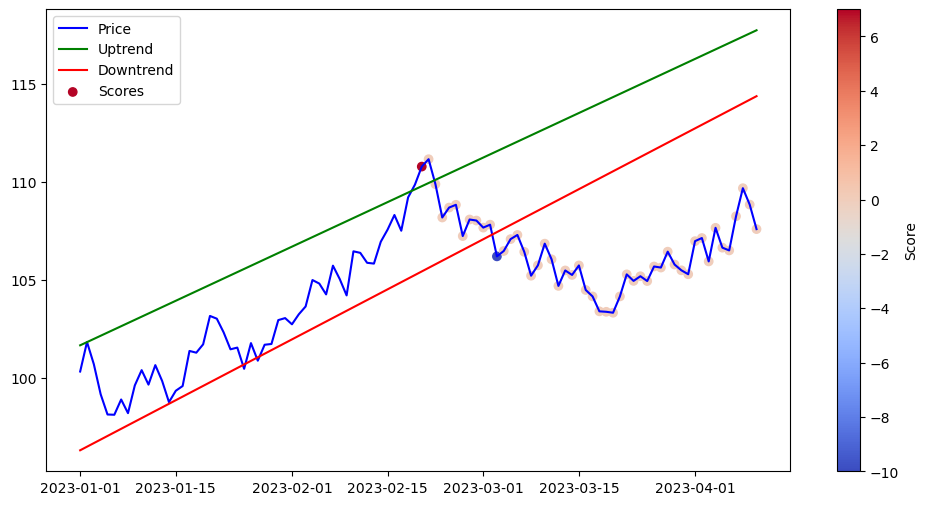

In [25]:
# Plot the data with trendlines and scores
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Price', color='blue')
plt.plot(df['Date'], df['Uptrend'], label='Uptrend', color='green')
plt.plot(df['Date'], df['Downtrend'], label='Downtrend', color='red')
plt.scatter(scored_df['Date'], scored_df['Price'], c=scored_df['Score'], cmap='coolwarm', label='Scores')
plt.colorbar(label='Score')
plt.legend()
plt.show()

In [29]:
# Sample data (replace with your actual data)
data = pd.DataFrame({
    'Date': pd.date_range('2023-01-01', periods=100),
    'Price': np.random.randn(100).cumsum() + 100
})



In [35]:
# Function to calculate channel
def calculate_channel(data, split_index):
    
    df = data.copy()
    df['Number'] = np.arange(len(df)) + 1
    first_part = df.iloc[:split_index].copy()
    
    # Calculate regression line for the center of the channel
    slope, intercept, _, _, _ = linregress(x=first_part['Number'], y=first_part['Price'])
    center_line = slope * df['Number'] + intercept

    # Calculate the channel boundaries
    first_part['Residuals'] = first_part['Price'] - (slope * first_part['Number'] + intercept)
    channel_width = first_part['Residuals'].abs().max()
    df['Channel_Top'] = center_line + channel_width
    df['Channel_Bottom'] = center_line - channel_width

    # Determine the channel direction
    total_trend = "upward" if slope > 0 else "downward"

    return df, total_trend, slope

# Function to score based on the channel
def score_channel(data, split_index, total_trend):
    second_part = data.iloc[split_index:].copy()
    second_part['Number'] = np.arange(len(second_part)) + split_index + 1

    scores = []
    was_breaking_top = False
    was_breaking_bottom = False

    for _, row in second_part.iterrows():
        price = row['Price']
        channel_top = row['Channel_Top']
        channel_bottom = row['Channel_Bottom']
        score = 0

        if total_trend == "upward" or total_trend == "downward":
            # Interactions with the top line of the channel
            if price > channel_top:
                if not was_breaking_top:
                    score = 10  # Break and remain above
                    was_breaking_top = True
            elif price == channel_top:
                score = -10  # Collision with the top
                was_breaking_top = False
            elif price < channel_top and was_breaking_top:
                score = -5  # Break and return under
                was_breaking_top = False

            # Interactions with the bottom line of the channel
            if price < channel_bottom:
                if not was_breaking_bottom:
                    score = -10  # Break and remain below
                    was_breaking_bottom = True
            elif price == channel_bottom:
                score = 10  # Collision with the bottom
                was_breaking_bottom = False
            elif price > channel_bottom and was_breaking_bottom:
                score = -5  # Break and return above
                was_breaking_bottom = False

        scores.append(score)

    second_part['Score'] = scores
    return second_part, sum(scores)



In [36]:
# Divide DataFrame into portions
split_index = len(data) // 2
df, total_trend, slope = calculate_channel(data, split_index)

# Score interactions with the channel in the second portion
scored_df, score = score_channel(df, split_index, total_trend)

score


-70

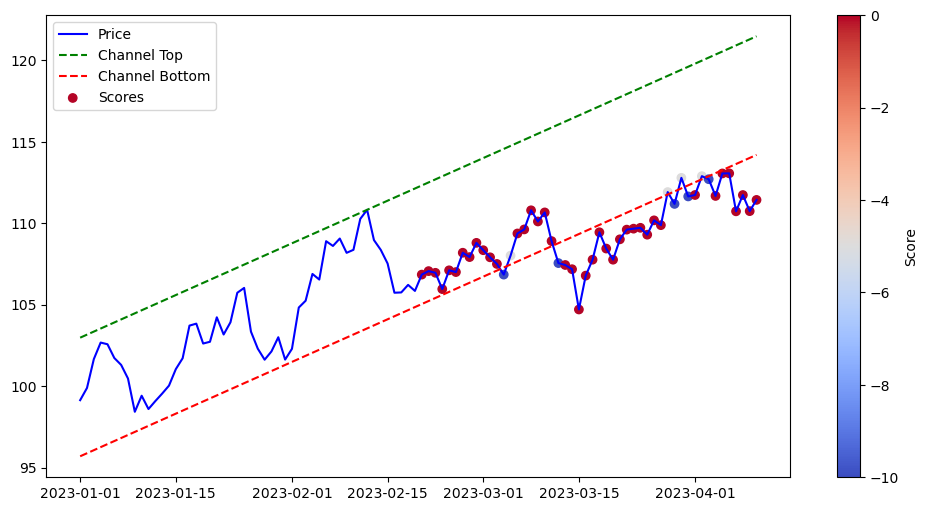

In [34]:
# Plot the data with channels and scores
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Price', color='blue')
plt.plot(df['Date'], df['Channel_Top'], label='Channel Top', color='green', linestyle='--')
plt.plot(df['Date'], df['Channel_Bottom'], label='Channel Bottom', color='red', linestyle='--')
plt.scatter(scored_df['Date'], scored_df['Price'], c=scored_df['Score'], cmap='coolwarm', label='Scores')
plt.colorbar(label='Score')
plt.legend()
plt.show()